# Generation of Datasets

In [331]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [42]:
def remove_outliers(df, cols):
    for col in cols:
        df = df[np.abs(stats.zscore(df[col]) <= 3)].reset_index(drop=True)
    return df

def generate_bpl_data(pop, bpl, bpl_cr):
    states = bpl['State.UT'].unique()
    states
    for state in states:
        perc = bpl[(bpl['State.UT'] == state) & (bpl['year'] == 2011)]['percent'].values[0]
        for year in range(2012, 2020):
            perc = perc + bpl_cr
            new_entry = pd.DataFrame({'State.UT':[state], 'percent':[perc], 'year':[year]})
            bpl = pd.concat([bpl, new_entry], axis=0)

    state = "ANDHRA PR"

    bpl = bpl[~((bpl['year'] > 2013) & (bpl['State.UT'] == state))]

    bpl = pd.merge(bpl, pop, on=['State.UT', 'year'])
    bpl['bpl_pop'] = bpl['percent'] * bpl['Population'] / 100
    bpl = bpl[(bpl['bpl_pop'] > 0)]
    bpl['log_bpl_pop'] = np.log1p(bpl['Population'])
    return bpl

Loading rice and wheat consumption datasets and removal of outliers in them.

In [346]:
rice = pd.read_excel("Data/rice.xlsx")
wheat = pd.read_excel("Data/wheat.xlsx")
print (rice.shape)

rice = remove_outliers(rice, ["offtake", "allotment"])
wheat = remove_outliers(wheat, ["offtake", "allotment"])
print (rice.shape)

(601, 5)
(586, 5)


Finding rice consuming and wheat consuming states

In [347]:
rice_summary = rice.groupby("State.UT").agg({"allotment":sum}).reset_index().\
                rename({"allotment":"rice_allotment"}, axis=1)
wheat_summary = wheat.groupby("State.UT").agg({"allotment":sum}).reset_index().\
                rename({"allotment":"wheat_allotment"}, axis=1)

rice_wheat = pd.merge(rice_summary, wheat_summary, on='State.UT', how='inner')
rice_wheat['perc_rice'] = rice_wheat['rice_allotment'] / (rice_wheat['rice_allotment'] + rice_wheat['wheat_allotment'])
rice_wheat['perc_wheat'] = rice_wheat['wheat_allotment'] / (rice_wheat['rice_allotment'] + rice_wheat['wheat_allotment'])

rice_wheat.head()

,State.UT,rice_allotment,wheat_allotment,perc_rice,perc_wheat
0,A&N ISLANDS,485.20,232.12,0.676407,0.323593
1,ANDHRA PR,49027.06,3712.78,0.929602,0.070398
2,ARUNACHAL,1843.87,210.01,0.897750,0.102250
3,ASSAM,29957.20,6564.82,0.820250,0.179750
4,BIHAR,52286.72,36073.22,0.591747,0.408253


Making total allotment and offtake from rice and wheat allotment-offtake state-year wise data

In [66]:
all_off = pd.merge(rice, wheat, on=['State.UT', 'year'], how='inner')
all_off['offtake'] = all_off["offtake_x"] + all_off["offtake_y"]
all_off['allotment'] = all_off['allotment_x'] + all_off['allotment_y']
all_off.drop(['offtake_x', 'offtake_y', 'allotment_x', 'allotment_y', 'zone_x', 'zone_y'], axis=1, inplace=True)
all_off['utilisation_ratio'] = all_off['offtake'] / all_off['allotment']
all_off = remove_outliers(all_off, ['offtake', 'allotment', 'utilisation_ratio'])
all_off.head()

,State.UT,year,offtake,allotment,utilisation_ratio
0,A&N ISLANDS,2003,22.39,48.77,0.459094
1,ARUNACHAL,2003,104.96,145.33,0.722218
2,ASSAM,2003,1510.92,2042.99,0.739563
3,BIHAR,2003,1424.66,5699.26,0.249973
4,CHANDIGARH,2003,1.72,87.82,0.019586


In [69]:
year_total_ao = all_off.groupby('year').agg({'allotment':sum, 'offtake':sum}).reset_index()
year_total_ao.head()

state_total_ao = all_off.groupby('year').agg({'allotment':sum, 'offtake':sum}).reset_index()
state_total_ao.head()

,year,allotment,offtake
0,2003,33339.66,17375.66
1,2004,34330.76,18574.06
2,2005,48210.39,25269.57
3,2006,48333.61,27877.11
4,2007,38947.82,33513.04


In [70]:
ur = pd.read_excel("Data/utilisation_ratio_state_wise_2010_2019.xlsx")
state_ao = pd.read_excel("Data/state_ao 2003-19.xlsx")

In [92]:
#Getting road length data
road_l = pd.read_excel("Data/Road Length 2010-16.XLSX")
road_l = pd.melt(road_l, var_name='year', value_name='ro_length', id_vars='State.UT')
road_l = road_l.dropna()
road_l['year'] = road_l['year'].astype(int)
road_l['ro_log_length'] = np.log1p(road_l['ro_length'])
road_l = remove_outliers(road_l, ["ro_length", "ro_log_length"])
road_l.head()

#Getting state highway length
sh_l = pd.read_excel("Data/SH Length 2011-16.xlsx")
sh_l = pd.melt(sh_l, var_name='year', value_name='sh_length', id_vars='State.UT')
sh_l = sh_l.dropna()
sh_l['sh_log_length'] = np.log1p(sh_l['sh_length'])
sh_l['year'] = sh_l['year'].astype(float)
sh_l = remove_outliers(sh_l, ["sh_log_length", "sh_length"])

#Getting railway length data
rw_l = pd.read_excel("Data/Railway Length 2011-17.xlsx")
rw_l = pd.melt(rw_l, var_name='year', value_name='rw_length', id_vars='State.UT')
rw_l = rw_l.dropna()
rw_l['rw_log_length'] = np.log1p(rw_l['rw_length'])
rw_l['year'] = rw_l['year'].astype(float)
rw_l = remove_outliers(rw_l, ["rw_length", "rw_log_length"])

#Getting GSDP data
gsdp = pd.read_excel("Data/GSDP Current Price 2011-20.xlsx")
gsdp = pd.melt(gsdp, var_name='year', value_name='gsdp', id_vars='State.UT')
gsdp['year'] = gsdp['year'].apply(lambda x: int(x[0:4]))
gsdp = gsdp.dropna()
gsdp['log_gsdp'] = np.log1p(gsdp['gsdp'])
gsdp.head()

,State.UT,year,ro_length,ro_log_length
0,A&N ISLANDS,2010,1302.0,7.172425
1,ANDHRA PR,2010,235678.0,12.370226
2,ARUNACHAL,2010,21122.0,9.958118
3,ASSAM,2010,239394.0,12.385870
4,BIHAR,2010,128034.0,11.760059


DCP Data Prepearation

In [237]:
rice['grain'] = 'rice'
wheat['grain'] = 'white'
df_dcp = pd.concat([rice, wheat], axis=0).reset_index()
rice.drop(['grain'], axis=1, inplace=True)
wheat.drop(['grain'], axis=1, inplace=True)
df_dcp['dcp'] = 0

dcp_status = pd.read_excel("Data/DCP Status.xlsx")
dcp_status = dcp_status.dropna().reset_index(drop=True)

#wef - with effect from
indexes = []
for idx, row in dcp_status.iterrows():
    year = row['wef']
    state = row['State.UT']
    grain = row['grain']
    idx = df_dcp[(df_dcp['year'] >= year) & (df_dcp['State.UT'] == state) & (df_dcp['grain'] == grain)].index
    df_dcp['dcp'][idx] = 1    

df_dcp.sample(5)

df_dcp['utilisation_ratio'] = df_dcp['offtake'] / df_dcp['allotment']
df_dcp.dropna(inplace=True)
df_dcp = df_dcp[df_dcp['utilisation_ratio'] <= 1]
df_dcp = remove_outliers(df_dcp, ["utilisation_ratio"])

,index,State.UT,year,offtake,allotment,zone,grain,dcp
249,249,J & K,2010,600.05,723.48,NORTH ZONE,rice,0
204,204,ASSAM,2009,1258.56,1449.19,N.E ZONE,rice,0
497,497,MADHYA PR,2017,957.38,1075.27,WEST ZONE,rice,1
1067,481,GOA,2017,12.39,13.17,WEST ZONE,white,0
368,368,UTTAR PR,2013,3044.05,3584.83,NORTH ZONE,rice,0


In [239]:
pop = pd.read_excel("Data/projected_population_by_state_2012_2036.xlsx")
pop['log_pop'] = np.log1p(pop['Population'])

bpl_perc2011 = pd.read_excel("Data/BPL data.xlsx")
bpl_perc2011.rename({"2011-12 Perc of Persons":"percent"}, axis=1, inplace=True)
bpl_perc2011['year'] = 2011

In [244]:
total_all_pop = pd.merge(all_off, pop, on=['State.UT', 'year'], how='inner')

In [249]:
total_all_pop.head()

,State.UT,year,offtake,allotment,utilisation_ratio,Population,log_pop
0,A&N ISLANDS,2011,20.41,40.60,0.502709,381000,12.850557
1,ARUNACHAL,2011,102.69,134.52,0.763381,1384000,14.140489
2,ASSAM,2011,2211.13,2914.49,0.758668,31206000,17.256121
3,BIHAR,2011,3802.68,5410.26,0.702865,104099000,18.460853
4,CHANDIGARH,2011,54.84,76.20,0.719685,1055000,13.869052


In [317]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Equation A

In [264]:
pop_alt_model = linear_model.LinearRegression().fit(total_all_pop[['Population']], total_all_pop['allotment'])

print (pop_alt_model.coef_, pop_alt_model.intercept_)

[4.82335241e-05] 88.87382471679825


### Equation B

Leasr BPL Change Rate  0.81


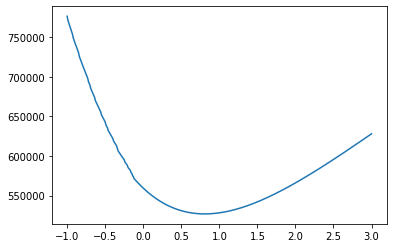

In [336]:
bpl_change_rate = []
ssr = []
for bpl_cr in np.arange(-1, 3.01, 0.01):
    bpl_cr = round(bpl_cr, 2)
    bpl = generate_bpl_data(pop, bpl_perc2011, bpl_cr)
    tbp = pd.merge(all_off, bpl, on=['State.UT', 'year'], how='inner')
    model = linear_model.LinearRegression().fit(tbp[['bpl_pop']], tbp['allotment'])
    pred = model.predict(tbp[['bpl_pop']])
    ssr.append(mean_squared_error(pred, tbp['allotment']))
    bpl_change_rate.append(bpl_cr)

bpl_cr = bpl_change_rate[ssr.index(min(ssr))]
print ("Leasr BPL Change Rate ", bpl_cr)

plt.plot(bpl_change_rate, ssr)

In [337]:
bpl = generate_bpl_data(pop, bpl_perc2011, bpl_cr)
tbp = pd.merge(all_off, bpl, on=['State.UT', 'year'], how='inner')

In [338]:
bpl_alt_fit = linear_model.LinearRegression().fit(tbp[['bpl_pop']], tbp['allotment'])

## Forecasts for futures

In [348]:
r = rice.copy()
w = wheat.copy()
r.rename({"allotment":"rice_allotment"}, axis=1, inplace=True)
w.rename({"allotment":"wheat_allotment"}, axis=1, inplace=True)
r.drop(["zone", "offtake"], axis=1, inplace=True)
w.drop(["zone", "offtake"], axis=1, inplace=True)
rw = pd.merge(r, w, on=['State.UT', 'year'], how='inner')

rw['rice_perc'] = rw['rice_allotment'] / (rw['rice_allotment'] + rw['wheat_allotment'])
rw['wheat_perc'] = rw['wheat_allotment'] / (rw['rice_allotment'] + rw['wheat_allotment'])

In [366]:
rw['rice_moving_perc'] = 0
rw['wheat_moving_perc'] = 0

Calculat moving percentage

In [367]:
for year in range(2006, 2020):
    for state in list(rw['State.UT'].unique()):
        df2 = rw[((rw['State.UT'] == state) & ((rw['year'] < year) & (rw['year'] >= year-3)))]
        r_m_p, w_m_p = df2['rice_perc'].mean(), df2['wheat_perc'].mean()
        idx = rw[((rw['State.UT'] == state) & (rw['year'] == year))].index
        if len(idx) > 0:
            rw['rice_moving_perc'][idx] = r_m_p
            rw['wheat_moving_perc'][idx] = w_m_p

In [369]:
rw.shape

(561, 9)

In [370]:
rw = rw[(rw['rice_moving_perc'] > 0) & (rw['wheat_moving_perc'] > 0)]
rw.shape

(465, 9)

In [371]:
rp = pd.merge(rw, pop, on=['State.UT', 'year'], how='inner')
rp = remove_outliers(rp, ["Population", "rice_allotment", "rice_moving_perc", "wheat_moving_perc"])

rice_pop_fit = linear_model.LinearRegression().fit(rp[['Population', 'rice_moving_perc']], rp['rice_allotment'])

In [374]:
wp = pd.merge(rw, pop, on=['State.UT', 'year'], how='inner')
wp = remove_outliers(wp, ["Population", "rice_allotment", "rice_moving_perc", "wheat_moving_perc"])
wheat_pop_fit = linear_model.LinearRegression().fit(wp[['Population', 'wheat_moving_perc']], wp['rice_allotment'])